In [1]:
import math
import os, sys
from typing import Dict, Tuple, List, Optional
import re
import random
from datetime import datetime
from argparse import ArgumentParser, ArgumentTypeError
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from performer_pytorch import PerformerLM

from tokenizers import BertWordPieceTokenizer, Encoding

from torchviz import make_dot

from adafactor import Adafactor

def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise ArgumentTypeError('Boolean value expected.')

parser = ArgumentParser()
parser.add_argument('-o', '--o', dest='output', default='./', help='Location of output(s)')
parser.add_argument('-c', '--use_cuda', type=str2bool, dest='use_cuda', default=True, help='Use cuda if cuda supported')
parser.add_argument('-a', '--artifacts', dest='artifacts', default='./', help='Directory to save artifacts such as checkpoints')
parser.add_argument('-e', '--epochs', type=int, dest='train_epochs', default=10, help='Number of epochs to train on')
parser.add_argument('-p', '--print_every', type=int, dest='print_every', default=100, help='After how many iterations to print a status')
parser.add_argument('-s', '--save_every', type=int, dest='save_every', default=0, help='After how many epochs before saving a checkpoint (0 to turn off)')
parser.add_argument('-b', '--batch_size', type=int, dest='batch_size', default=1, help='Batch size to train on')

args, unknown = parser.parse_known_args()

use_cuda = args.use_cuda

device = 'cuda' if torch.has_cuda and use_cuda else 'cpu'

model_dir = args.output
artifacts_dir = args.artifacts

train_epochs = max(args.train_epochs, 20)
print_every = max(args.print_every, 1)
save_every = max(args.save_every, 0)
batch_size = max(args.batch_size, 1)

tokenizer = BertWordPieceTokenizer('data/bert-base-uncased-vocab.txt', lowercase=True)

# Data Parsing
Parse through subtitles

In [2]:
SOS_TOKEN = '<sos>'
EOS_TOKEN = '<eos>'
UNK_TOKEN = '<unk>'
PAD_TOKEN = '<pad>'
SEP_TOKEN = '<sep>'

multiplier = [60, 60 * 60, 24 * 60 * 60]
def get_time(timestr: str) -> int:
    time = timestr.split(':')
    final_time = 0
    ms = float(time[-1]) * 1000
    final_time += int(ms)
    for i in range(len(time)-2):
        t = time[-2-i]
        final_time += multiplier[i] * int(t)
    return final_time

normalize_pattern = re.compile(r'(\{[\\\*][\w\(\)\\\,\*]*|\})', re.M)
sub_space = re.compile(r'(\{|\\[nN])', re.M)
insert_space = re.compile(r'([\w\"])([\.\!\,\?])')
def normalize_text(text: str) -> str:
    text = normalize_pattern.sub('', text)
    text = sub_space.sub(' ', text)
    text = re.sub(r'([\'\"])', r' \1 ', text)
    text = re.sub(r'([\.\!\?])(\w)', r'\1 \2', text)
    text = ' '.join(text.split())
    return insert_space.sub(r'\1 \2', text)

number_match = re.compile(r'\d+')
def match_num(text: str) -> int:
    x = number_match.findall(text)
    return int(x[0] if len(x) > 0 else 0)

class ParsedVocab:
    """The parsed vocabulary."""

    def __init__(self, words: List[Tuple[str, int]], longest: int = 0):
        words.sort(key=lambda x : x[1], reverse=True)
        # words = [('<sos>', 1), ('<eos>', 1)] + words
        words = [(PAD_TOKEN, 0), (UNK_TOKEN, 0), (SEP_TOKEN, 0)] + words
        self._word2freq = words
        self._word2ind = {}
        self._words = list(map(lambda x: x[0], words))
        self._longest = longest

        for i, (w, _) in enumerate(words):
            self._word2ind[w] = i

    def __getitem__(self, i) -> str:
        return self._words[i]

    def __str__(self) -> str:
        return f'Parsed Vocabulary ({len(self._words)} words)'
    
    def get_words(self) -> List[str]:
        return self._words
    
    def get_index(self, word) -> int:
        if word in self._word2ind:
            return self._word2ind[word]
        return -1

    def sen_to_seq(self, sentence: str, seq_len: int = 0, add_tokens: bool = True, add_pad: bool = False) -> List[int]:
        sentence = normalize_text(sentence)
        if seq_len <= 0:
            seq_len = self._longest
        l = []
        if add_tokens:
            sentence = f'{SOS_TOKEN} {sentence}'
        s = sentence.split()
        for i in range(min(len(s), seq_len - add_tokens)):
            word = s[i]
            if word in self._word2ind:
                l.append(self._word2ind[word])
            else:
                l.append(self._word2ind[UNK_TOKEN])
        if add_tokens:
            l += [self._word2ind[EOS_TOKEN]]
        if len(s) < seq_len and add_pad:
            l += [self._word2ind[PAD_TOKEN]] * (seq_len - len(l))
        return l

    def conv_to_seq(self, conversation: List[Dict[str, object]], max_seq_len: int = 0) -> List[int]:
        l = [self._word2ind[SOS_TOKEN]]
        for conv in conversation:
            l.extend(self.sen_to_seq(conv['line'], add_tokens=False))
            l.append(self._word2ind[SEP_TOKEN])

        if len(l) > 0:
            l = l[:max_seq_len]
            l[-1] = self._word2ind[EOS_TOKEN]
        l += [self._word2ind[PAD_TOKEN]] * (max_seq_len - len(l))
        return l
        

    def gen_mask(self, tokenized_sentence: List[int]) -> List[bool]:
        """Creates a mask for the given tokenized sentence.

        >>> pv = ParsedVocab([('<sos>', 0), ('<eos>', 0), ('hi', 0)])
        >>> x = pv.sen_to_seq('<sos> hi <eos> <unk> <unk>', )
        >>> pv.gen_mask(x)
        [1, 1, 1, 0, 0]
        """
        l = [True] * len(tokenized_sentence)
        i = len(tokenized_sentence) - 1
        while i >= 0 and tokenized_sentence[i] == self._word2ind[PAD_TOKEN]:
            l[i] = False
            i -= 1
        return l

class Vocab:
    """Regulard vocabulary for holding the conversations and number of words."""

    DEFAULT_CONTEXT = 'default'

    def __init__(self, conversation_depth: int = 4):
        self.words = {}
        self._context = Vocab.DEFAULT_CONTEXT
        self.conversations = {}
        self._held_conversations = {}
        self.conversation_depth = conversation_depth
        self.longest = 0
        self.longest_tokenized = 0

    def add_word(self, word: str) -> None:
        word = word.lower()
        if not word in self.words:
            self.words[word] = 0
        self.words[word] += 1

    def add_sentence(self, sentence: str) -> None:
        sentence = f'{SOS_TOKEN} {sentence} {EOS_TOKEN}'
        [self.add_word(s) for s in sentence.split()]

    def switch_context(self, new_context: str) -> None:
        if self._context in self._held_conversations and len(self._held_conversations[self._context]) > self.conversation_depth:
            self.conversations[self._context].append(self._held_conversations[self._context][
                -self.conversation_depth:
            ])
        self._context = new_context

    def add_conversation(self, conversation: Dict[str, object]) -> None:
        if not self._context in self.conversations:
            self.conversations[self._context] = []
            self._held_conversations[self._context] = [conversation]
            return
        self.add_line(conversation)
        lc = self._held_conversations[self._context][-1]
        line = lc['line'].split()
        if len(line) > self.longest:
            self.longest = len(line)
        tokenized = tokenizer.encode(lc['line'])
        if len(tokenized.ids) > self.longest_tokenized:
            self.longest_tokenized = len(tokenized.ids)
    
    def add_line(self, conversation: Dict[str, object]) -> bool:
        if not self._context in self._held_conversations or len(self._held_conversations[self._context]) == 0:
            self._held_conversations[self._context] = [conversation]
            return True
        hc = self._held_conversations[self._context] # Held Conversation
        lc = hc[-1] # Last conversation
        # Same speaker
        if (len(lc['speaker']) > 0 and lc['speaker'] == conversation['speaker']) or \
            (len(lc['speaker']) == 0 and len(conversation['speaker']) == 0 and len(conversation['line']) > 0 and conversation['line'][0].islower()) and \
            conversation['when'] - lc['when'] < 1000 * 60 * 1.5:
            hc[-1]['when'] = conversation['when']
            hc[-1]['line'] += f" {conversation['line']}"
            return False
        if len(self._held_conversations[self._context]) >= 2:
            self.conversations[self._context].append(self._held_conversations[self._context][
                -min(self.conversation_depth, len(hc)):
            ])
        hc.append(conversation)
        return True

    def parse_vocab(self) -> ParsedVocab:
        words = list(self.words.items())
        return ParsedVocab(words, self.longest)

In [3]:
FOLDERS = ['ditfxx_subs', 'steins_gate_subs']
CONVERSATION_DEPTH = 4

vocab = Vocab(CONVERSATION_DEPTH)

for folder in FOLDERS:
    dir = os.listdir(os.path.join('data', folder))
    dir.sort(key=match_num)
    print(f'Parsing folder: {folder}')
    for f in dir:
        filepath = os.path.join(os.getcwd(), 'data', folder, f)
        if not os.path.isfile(filepath): continue
        print(f'  Opening file: {f}')
        with open(filepath, 'r', encoding='utf-8', errors='ignore') as sub_file:
            is_event = False
            line = True
            while not is_event and line:
                line = sub_file.readline()
                if not line: break
                if line.rstrip() == "[Events]":
                    is_event = True
            current_format = False
            current_conversation = []
            
            vocab.switch_context(f)
            line = True
            # for line in sub_file.readlines():
            while line:
                try:
                    line = sub_file.readline()
                except UnicodeDecodeError:
                    print('    Error decoding a line, skipped.')
                if line.startswith('Format:'):
                    line = line[len('Format:'):].strip().split(', ')
                    current_format = line
                    continue
                if current_format == False or not line.startswith('Dialogue:'): continue
                line = line[len('Dialogue:'):].strip().split(',')
                line[len(current_format)-1] = ','.join(line[len(current_format)-1:])
                dialogue = dict(zip(current_format, line))
                if not dialogue['Style'] in ['main', 'Default', 'italics', 'flashback']: continue
                # Extract variables
                speaker = dialogue['Name']
                text = normalize_text(dialogue['Text'])
                time = get_time(dialogue['Start'])
                style = dialogue['Style']

                # if len(current_conversation) > 0 and time - current_conversation[-1]['when'] > 1000 * 60 * 2:
                #     current_conversation = []
                # if len(current_conversation) > 0 and ((len(speaker) > 0 and current_conversation[-1]['speaker'] == speaker) or 
                # (len(speaker) == 0 and len(dialogue['Text']) > 0 and dialogue['Text'][0].islower())):
                #     current_conversation[-1]['line'] += f' {text}'
                #     current_conversation[-1]['when'] = time
                # else:
                #     vocab.add_conversation(current_conversation)
                #     current_conversation.append({
                #         'speaker': speaker,
                #         'line': text,
                #         'when': time
                #     })
                # if len(current_conversation) > CONVERSATION_DEPTH:
                #     current_conversation = current_conversation[CONVERSATION_DEPTH - len(current_conversation):]
                # if len(current_conversation) == 1:
                #     continue
                vocab.add_conversation({
                    'speaker': speaker,
                    'line': text,
                    'when': time,
                    'style': style
                })
                vocab.add_sentence(text)
            
# tokenizer.enable_padding(length=vocab.longest_tokenized)
# pv = vocab.parse_vocab()
convos = 0
for k, c in vocab.conversations.items():
    convos += len(c)
print(f'Done! Num conversations: {convos}, num words: {len(vocab.words)}, longest convo: {vocab.longest_tokenized}')
# print(words[:100])

Parsing folder: ditfxx_subs
  Opening file: DitFXX (1).ass
  Opening file: DitFXX (2).ass
  Opening file: DitFXX (3).ass
  Opening file: DitFXX (4).ass
  Opening file: DitFXX (5).ass
  Opening file: DitFXX (6).ass
  Opening file: DitFXX (7).ass
  Opening file: DitFXX (8).ass
  Opening file: DitFXX (9).ass
  Opening file: DitFXX (10).ass
  Opening file: DitFXX (11).ass
  Opening file: DitFXX (12).ass
  Opening file: DitFXX (13).ass
  Opening file: DitFXX (14).ass
  Opening file: DitFXX (15).ass
  Opening file: DitFXX (16).ass
  Opening file: DitFXX (17).ass
  Opening file: DitFXX (18).ass
  Opening file: DitFXX (19).ass
  Opening file: DitFXX (20).ass
  Opening file: DitFXX (21).ass
  Opening file: DitFXX (22).ass
  Opening file: DitFXX (23).ass
Parsing folder: steins_gate_subs
  Opening file: Steins;Gate 01.ass
  Opening file: Steins;Gate 02.ass
  Opening file: Steins;Gate 03.ass
  Opening file: Steins;Gate 04.ass
  Opening file: Steins;Gate 05.ass
  Opening file: Steins;Gate 06.ass
  

In [4]:
x = list(vocab.conversations)
c = vocab.conversations[x[0]]

for cc in c[:5]:
    l = [x['line'] for x in cc]
    print(f'\n{l}')
    output = tokenizer.encode_batch(l)
    # print([o.tokens for o in output])
    # print([o.tokens[0 if i == 0 else 1:] for i, o in enumerate(output)])
    # cat = sum([o.ids[0 if i == 0 else 1:] for i, o in enumerate(output)], [])
    # output[1].pad(100)
    # print(output[0].merge(output[1:2]).ids)
    # print(tokenizer.decode(cat))
    # output = tokenizer.encode(l[0], pair=l[1])
    output = Encoding.merge(output, growing_offsets=False)
    print(output.tokens)

print(tokenizer.get_vocab_size())

tokenizer.enable_padding()
print(tokenizer.padding)

c[0][:]


['The Jian , also known as " the bird that shares wings , " only possesses one wing . Unless a male and female pair lean on each other and act as one , they \' re incapable of flight . They \' re imperfect , incomplete creatures .', 'But for some reason , their way of life struck me as profoundly beautiful . It was beautiful , I felt . I wanna take a bath .']
['[CLS]', 'the', 'jian', ',', 'also', 'known', 'as', '"', 'the', 'bird', 'that', 'shares', 'wings', ',', '"', 'only', 'possesses', 'one', 'wing', '.', 'unless', 'a', 'male', 'and', 'female', 'pair', 'lean', 'on', 'each', 'other', 'and', 'act', 'as', 'one', ',', 'they', "'", 're', 'incapable', 'of', 'flight', '.', 'they', "'", 're', 'imperfect', ',', 'incomplete', 'creatures', '.', '[SEP]', '[CLS]', 'but', 'for', 'some', 'reason', ',', 'their', 'way', 'of', 'life', 'struck', 'me', 'as', 'profoundly', 'beautiful', '.', 'it', 'was', 'beautiful', ',', 'i', 'felt', '.', 'i', 'wanna', 'take', 'a', 'bath', '.', '[SEP]']

['The Jian , al

[{'speaker': 'Zero2',
  'line': 'The Jian , also known as " the bird that shares wings , " only possesses one wing . Unless a male and female pair lean on each other and act as one , they \' re incapable of flight . They \' re imperfect , incomplete creatures .',
  'when': 21670,
  'style': 'italics'},
 {'speaker': 'Z2',
  'line': 'But for some reason , their way of life struck me as profoundly beautiful . It was beautiful , I felt . I wanna take a bath .',
  'when': 150,
  'style': 'italics'}]

# Define Model
Defining the actual AI model

torch.Size([1, 843, 30522])
torch.Size([1, 843])


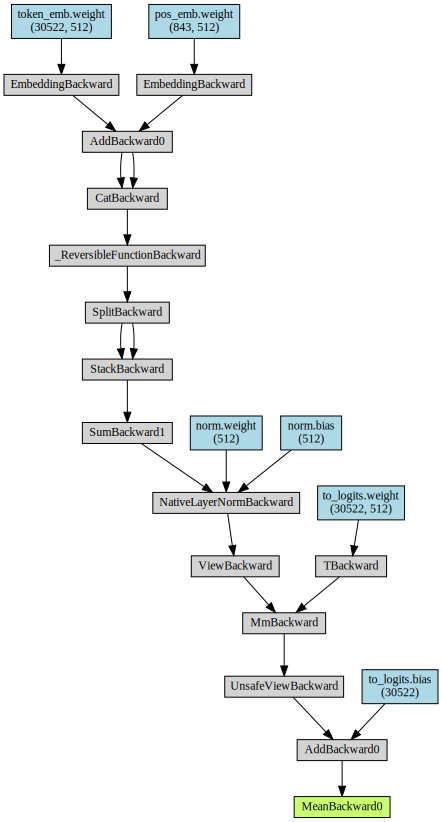

In [5]:
# 3 Sentences with 2 delims
seq_len = vocab.longest_tokenized * (vocab.conversation_depth - 1)

# Thanks to
# https://github.com/lucidrains/performer-pytorch
model = PerformerLM(
    num_tokens=tokenizer.get_vocab_size(),
    max_seq_len=seq_len,
    dim=512,
    depth=6,
    heads=8,
    causal=False,
    nb_features=256,
    generalized_attention=True,
    kernel_fn=nn.LeakyReLU(),
    reversible=True,
    ff_chunks=10,
    use_scalenorm=True,
    use_rezero=True
)

x = torch.randint(0, tokenizer.get_vocab_size(), (1, seq_len))
mask = torch.ones_like(x).bool()

y = model(x, mask=mask)

print(y.size())
print(x.shape)

if device == 'cuda':
    model = model.cuda()

make_dot(y.mean(), params=dict(model.named_parameters()))

# Train model

In [6]:
optimizer = Adafactor(model.parameters())
criterion = nn.CrossEntropyLoss()

def top_k(logits, thres = 0.9):
    k = int((1 - thres) * logits.shape[-1])
    val, ind = torch.topk(logits, k)
    probs = torch.full_like(logits, float('-inf'))
    probs.scatter_(1, ind, val)
    return probs

class ConversationIter:

    def __init__(self, conversations: List[List[object]], max_seq_len: int, batch_size: int = 1):
        self._context = 0
        self._conversations = conversations
        self.max_seq_len = max_seq_len

        self._batch_size = batch_size

        self._i = 0

        if len(self._conversations) == 0:
            raise Exception("Not enough conversations in the Vocab, could not make ConversationIter")

    def __iter__(self):
        self._context = random.randrange(0, len(self._conversations))
        self._i = 0
        return self

    def __next__(self) -> Tuple[Encoding, Encoding]:
        conv = self._conversations[self._context]
        if self._i >= len(conv):
            raise StopIteration

        inputs, targets = [], []
        for b in range(self._batch_size):
            try:
                x = conv[self._i]
                l = [tokenizer.encode(y['line']) for y in x]
                # i = Encoding.merge()
                i = Encoding.merge(l[:-1])
                t = l[-1]
                i.pad(seq_len)
                t.pad(seq_len)

                inputs.append(i)
                targets.append(t)

                self._i += 1
            except IndexError:
                if min(len(inputs), len(targets)) == 0:
                    raise StopIteration
                else:
                    return inputs, targets
        return inputs, targets

def train(conv_iter: ConversationIter):
    model.train()
    accrued_loss = 0
    start = datetime.now()
    for i, (inputs, targets) in enumerate(conv_iter):
        # mask = torch.tensor(pv.gen_mask(input))
        mask = torch.tensor([inp.attention_mask for inp in inputs]).bool()

        inputs = torch.tensor([inp.attention_mask for inp in inputs])
        targets = torch.tensor([tar.attention_mask for tar in targets])

        inputs.to(device)
        targets.to(device)
        mask.to(device)

        if device == 'cuda':
            inputs = inputs.cuda()
            targets = targets.cuda()
            mask = mask.cuda()

#         input = F.one_hot(input, len(pv.get_words()))
#         input.transpose_(0, 1)

#         print(input.shape, target.shape)

        optimizer.zero_grad()
        output = model(inputs, mask=mask)
        # output.transpose_(1, 2)
        loss = criterion(output.transpose(1, 2), targets)
        loss.backward()
        optimizer.step()
        
        accrued_loss += loss.item()
        
        if (i + 1) % print_every == 0:
            print(f'  Iter {i+1} (Took {(datetime.now() - start).total_seconds():.3f}s): AverageLoss: {accrued_loss/print_every:.4f}')
            accrued_loss = 0
            start = datetime.now()

In [7]:
conversations = list(vocab.conversations.values())

train_set, test_set = train_test_split(conversations, test_size=0.2)

train_iter = ConversationIter(train_set, seq_len, batch_size=batch_size)
test_iter = ConversationIter(test_set, seq_len)

def save_checkpoint(epoch: int):
    Path(os.path.join(artifacts_dir, 'checkpoints')).mkdir(parents=True, exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, os.path.join(artifacts_dir, 'checkpoints', f'amadeus-performer-{epoch}.pt'))

print(f'Starting train on device: {device}\n')
for epoch in range(train_epochs):
    prompt = f'Training epoch #{epoch+1} of {train_epochs}:'
    print(f'{prompt}\n{"=" * len(prompt)}')

    total = datetime.now()
    train(train_iter)

    print(f'Epoch {epoch+1} took {(datetime.now()-total).total_seconds():.3f}s')

    if save_every > 0 and (epoch + 1) % save_every == 0:
        print('Saving checkpoint...')
        save_checkpoint(epoch + 1)

    print('\n\n')

print(f'Finished training')
Path(os.path.join(model_dir, 'models')).mkdir(parents=True, exist_ok=True)
torch.save(model, os.path.join(model_dir, 'models', f'amadeus-performer-{datetime.now()}.pt'))

Starting train on device: cuda

Training epoch #1 of 20:


RuntimeError: CUDA out of memory. Tried to allocate 1.54 GiB (GPU 0; 6.00 GiB total capacity; 3.36 GiB already allocated; 201.25 MiB free; 3.43 GiB reserved in total by PyTorch)

In [23]:
# model.eval()

# history = []

# while True:
#     x = input('hi')
#     if x == 'exit' or len(x) == 0:
#         break

#     history.append(tokenizer.encode(x))
#     if len(history) > vocab.conversation_depth - 1:
#         history = history[-vocab.conversation_depth - 1:]
#     tokens = Encoding.merge(history[:])
#     tokens.pad(seq_len)
#     mask = torch.tensor(tokens.attention_mask).bool()
#     i = torch.tensor(tokens.ids).unsqueeze(0)
#     mask.unsqueeze_(0)

#     if device == 'cuda':
#         i = i.cuda()
#         mask = mask.cuda()

#     output = model(i, mask=mask)
#     print(output.squeeze(0).shape)
#     topk, topi = output.squeeze(0).topk(1)
#     topi.squeeze_(1)
#     sentence = tokenizer.decode(topi.tolist())
#     print(f'> {x}')
#     print(sentence)
#     print(output[:, -1, :].shape)
#     topk, topi = output[:, -1, :].topk(1)
#     print(topi.item())

torch.Size([843, 30522])
> hello
you's..
torch.Size([1, 30522])
0
